# LangChain + LangGraph: 25‑Minute Quickstart


This hands-on notebook gives you a fast tour of core concepts:
- Prompt Templates
- Chat Models (OpenAI)
- Chaining / LCEL (basic)
- Structured Output
- Tool Calling
- Workflows with LangGraph
- Agents with LangGraph


## 1) Setup



Set your OpenAI key (skip if already in your shell env).

In [7]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")
# os.environ["OPENAI_API_KEY"] = "sk-..."  # <-- Prefer setting in your .env instead of hardcoding


True

## 2) Prompt Templates

LangChain helps you compose prompts in a structured, reusable way.
We'll use `ChatPromptTemplate` to create a multi-turn style prompt.


In [1]:
from prompts import DATE_ASSISTANT_SYSTEM_PROMPT
from datetime import datetime
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", DATE_ASSISTANT_SYSTEM_PROMPT),
    ("human", "{user_query}")
])

example_user_query = """
What is tomorrow's date?
"""

messages = prompt.format_messages(user_query = example_user_query, 
                                    todays_date = datetime.now().strftime("%Y-%m-%d"))  # Shows message objects ready for a chat model

messages


[SystemMessage(content="\n\nYou are a helpful and accurate date assistant. \nYou are given a user's request, and today's date. Your job is to accurately infer the date from the user's request.\n\ntoday's date : 2025-10-15\n\nchat_history:\n\n", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="\nWhat is tomorrow's date?\n", additional_kwargs={}, response_metadata={})]

## 3) Chat Models (OpenAI)

We'll call OpenAI via `langchain-openai`. The default model below is a fast, reasonably capable chat model.


In [2]:
from langchain_openai import ChatOpenAI

# Tip: You can switch models later, e.g. "gpt-4o-mini", "o4-mini", etc.
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
response = llm.invoke(messages)
print(response.content)


Tomorrow's date is 2025-10-16.


## 4) Chaining with LCEL (LangChain Expression Language)

LCEL lets you pipe components together with `|` for clean, testable flows.


In [3]:
from langchain_core.output_parsers import StrOutputParser

chain = prompt | llm | StrOutputParser()


print(chain.invoke({ 'user_query' : example_user_query, 
                    'todays_date' : datetime.now().strftime("%Y-%m-%d") }))


Tomorrow's date is 2025-10-16.


## 5) Structured Output

When you need JSON you can trust, use Pydantic schemas and `with_structured_output`.  
This guides the model to return well-typed data (and validates it).

In [4]:
from typing import List, Optional, TypedDict
from pydantic import BaseModel, Field
from prompts import DATE_EXTRACTOR_PROMPT_TEMPLATE

# You can define structure with Pydantic
class DateRange(BaseModel):
    start_date: str = Field(default = None, description="Start Date of the date range")
    end_date: str = Field(default = None, description="End Date of the date range")

# OR you can define structure with TypedDict
# class DateRange(TypedDict):
#     start_date: str
#     end_date: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

structured_llm = llm.with_structured_output(DateRange)

prompt = ChatPromptTemplate.from_messages([
    ("system", DATE_EXTRACTOR_PROMPT_TEMPLATE),
    ("human", "{user_query}")
])


user_query = "I need time off for the next 4 days"
todays_date = datetime.now().strftime("%Y-%m-%d")


chain = prompt | structured_llm

llm_response = chain.invoke({'todays_date': todays_date, 'user_query': user_query})
llm_response


DateRange(start_date='2025-10-16', end_date='2025-10-19')

## 6) Tool Calling

Models can choose from functions (tools) you expose.  
We'll define a simple calculator tool and let the model decide when to use it.


In [5]:
from langchain.tools import tool
from langchain_core.messages import HumanMessage
import math

@tool
def circle_area(radius: float) -> float:
    """Return the area of a circle for a given radius."""
    return math.pi * radius * radius

tools = [circle_area]

# Bind tools to the model so it can decide to call them
llm_with_tools = llm.bind_tools(tools)

msg = HumanMessage(content="I have a circular garden of radius 3. What's the area?")
ai_msg = llm_with_tools.invoke([msg])

print("Model output Type", type(ai_msg))
print("Model output", ai_msg)
print("Tool calls (if any):", getattr(ai_msg, "tool_calls", None))

# If a tool call is present, execute it and return a final answer:

# final = None
# if getattr(ai_msg, "tool_calls", None):
#     for tool_call in ai_msg.tool_calls:
#         if tool_call["name"] == "circle_area":
#             r = float(tool_call["args"]["radius"])
#             result = circle_area.invoke({"radius": r})
#             final = f"The area is approximately {result:.2f} square units."
# else:
#     final = ai_msg.content

# print("Final:", final)


Model output Type <class 'langchain_core.messages.ai.AIMessage'>
Model output content='' additional_kwargs={'tool_calls': [{'id': 'call_grYEroF463QYIchLo7Q0abTK', 'function': {'arguments': '{"radius":3}', 'name': 'circle_area'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 62, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CQrrYdrU6miqBS1t9YnmYJGLPsUWU', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--26d7e6c9-0e6c-43fd-958c-2c0dbbb59624-0' tool_calls=[{'name': 'circle_area', 'args': {'radius': 3}, 'id': 'call_grYEroF463QYIchLo7Q0abTK', 'type': 'tool_call'}] usage_metadata={'input_tokens': 62, 'output_tokens': 

## 7) LangGraph: Workflows

LangGraph builds **stateful** graphs for control flow (branching, loops, retries).  
We'll create a tiny graph with one node that calls the model, and a conditional router.

![Diagram](./notebook_images/nodes_state_edges.png)


In [6]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage, AIMessage
from pydantic import BaseModel, Field
from prompts import INTENT_DETECTION_TEMPLATE

#state
class GraphState(TypedDict):
    messages: List[AnyMessage]


In [8]:
#Define the graph nodes

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


def intent_node(state: GraphState) -> GraphState:

    class Intent(BaseModel):
        intent: str = Field(..., description="User intent. One of:  TIMEOFF, GREETING, OTHER")

    structured_llm = llm.with_structured_output(Intent)
    prompt = ChatPromptTemplate.from_messages([('system', INTENT_DETECTION_TEMPLATE)] + state['messages'])
    chain = prompt | structured_llm
    response = chain.invoke(state)

    return {"messages": state["messages"] + [AIMessage(content= response.intent)]}

def time_off_node(state: GraphState) -> GraphState:
    ai_msg = AIMessage(content="Sure, I can help you with your time off request")
    return {"messages": state["messages"] + [ai_msg]}

def greeting_node(state: GraphState) -> GraphState:
    ai_msg = AIMessage(content="Hello, how can I help you today?")
    return {"messages": state["messages"] + [ai_msg]}

def other_node(state: GraphState) -> GraphState:
    ai_msg = AIMessage(content="I'm sorry, I don't understand. Please try again.")
    return {"messages": state["messages"] + [ai_msg]} 

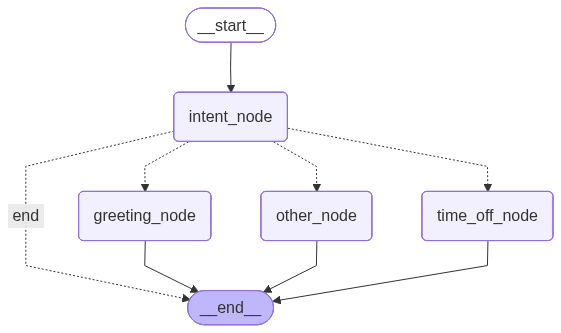

In [10]:
  

# Initialize the graph
graph = StateGraph(GraphState)
graph.add_node("intent_node", intent_node)
graph.add_node("time_off_node", time_off_node)
graph.add_node("greeting_node", greeting_node)
graph.add_node("other_node", other_node)

# Simple router: route to the correct branch based on the intent
def router(state: GraphState) -> str:
    last = state["messages"][-1]
    text = getattr(last, "content", "").lower()

    
    if text == "timeoff":
        return "time_off_node"
    elif text == "greeting":
        return "greeting_node"
    elif text == "other":
        return "other_node"
    else:
        return 'end'

# Add edges
graph.add_edge(START, "intent_node")
graph.add_conditional_edges("intent_node", router, {"end": END, "time_off_node": "time_off_node", "greeting_node": "greeting_node", "other_node": "other_node"})


workflow = graph.compile()
workflow

In [11]:
user_query = "Hello"
# user_query = "I would like to apply for time off"
# user_query = "What is the weather like in SF"

response = workflow.invoke({"messages": [HumanMessage(content= user_query)]})
response

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}),
  AIMessage(content='GREETING', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={})]}

In [12]:
response["messages"][-1].content

'Hello, how can I help you today?'

## 8) LangGraph: Agents (Prebuilt ReAct)

LangGraph includes prebuilt agent constructors like `create_react_agent`.  
We'll give the agent a couple of trivial tools and see how it plans + acts.


![Diagram](./notebook_images/react.png)

In [18]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AnyMessage, AIMessage, ToolMessage

@tool
def to_celsius(f: float) -> float:
    """Convert Fahrenheit to Celsius"""
    return (f - 32) * 5/9

@tool
def to_fahrenheit(c: float) -> float:
    """Convert Celsius to Fahrenheit"""
    return (c * 9/5) + 32

agent = create_react_agent(llm, tools=[to_celsius, to_fahrenheit])

# The agent returns a stream of steps; we can iterate until it yields a final answer.
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Single turn
events = agent.stream(
    {"messages": [HumanMessage(content="It's 77F outside. What's that in Celsius, rounded to 1 decimal?")]},
    config={"configurable": {"thread_id": "demo"}, "checkpoint": memory},
)

for event in events:
    print(event)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rBLjoeV56y6iDyjmYZIR7PBO', 'function': {'arguments': '{"f":77}', 'name': 'to_celsius'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 80, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CQrznrpqEUBJY5IQShCnaqATJj2Ji', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4143abea-c59e-4750-9d57-b789b1614f90-0', tool_calls=[{'name': 'to_celsius', 'args': {'f': 77}, 'id': 'call_rBLjoeV56y6iDyjmYZIR7PBO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 15, 'total_tokens': 95, 'input_token_details': {'